# Exploratory Analysis of the SkillCraft1_Dataset

## Introduction

**Starcraft II: Wings of Liberty** is a strategy video game in real time developped and edited by *Blizzard Entertainment*. It is a multiplayer video-game, playable on Windows and Mac OS X and has been released in 2010.
It takes place in the XXVIth century and relates the battles between three  species who want to dominate a part of the Milky Way: Koprulu Sector.  
Players can either play against the game's AI or against other palyers. According to their level, players are dispatched in eight different leagues from Bronze to Professionnal. Players can train themselves with the game's AI first and also change the speed of the game. Therefore we will be able to provide information to new players as to what to implement to have the level of a specific league. Also, if a players starts playing online after playing solo, we would be able to put him / her in a league adapted to their level by analyzing their stats. This way, they will not feel bored or defeated and will enjoy playing.   
**SkillCraft1** dataset is composed of 20 attributes and 3395 instances. It has been donated in 2013 and we'll aim to predict the players' league according to the gathered data.  
Data has been collected thanks to telemetry from 3 340 StarCraft II players of 7 levels. They were contacted through online gaming communities and social media and allowed the gathering of a replay file (a recording of the commands issued in a game). Concerning the 35 other individuals, data has been collected through replays of professional games on gaming websites. 

## Importing our libraries

In [115]:

import numpy as np
from numpy import set_printoptions
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import sklearn
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


## Loading the dataset

In [116]:
starcraft_data = pd.read_csv("SkillCraft1_Dataset.csv", na_values = '?')
starcraft_data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30.0,10.0,200.0,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19.0,20.0,400.0,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32.0,10.0,500.0,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [117]:
df = pd.DataFrame(starcraft_data)

The code below is used to create a file storing our dataframe only with the columns that we will end up using and having the last row as the mean of all the rows.  
This dataframe will be used in the Django API so that we'll only ask a few features (the most important ones) to our user, not the 15 ones.

In [118]:
to_drop_pkl = ['LeagueIndex', 'Age', 'GameID', 'HoursPerWeek', 'TotalHours']
df_pkl = df.drop(columns = to_drop_pkl)
df_pkl.to_pickle('./df.pkl')
test = df_pkl.append(pd.Series(df_pkl.mean()), ignore_index=True)
test.to_pickle('./df_with_mean.pkl')

In [119]:
print("Data types:")
df.dtypes

Data types:


GameID                    int64
LeagueIndex               int64
Age                     float64
HoursPerWeek            float64
TotalHours              float64
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

### Attribute information:

1. GameID: Unique ID number for each game (integer)
2. LeagueIndex: Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)
3. Age: Age of each player (integer)
4. HoursPerWeek: Reported hours spent playing per week (integer)
5. TotalHours: Reported total hours spent playing (integer)
6. APM: Action per minute (continuous)
7. SelectByHotkeys: Number of unit or building selections made using hotkeys per timestamp (continuous)
8. AssignToHotkeys: Number of units or buildings assigned to hotkeys per timestamp (continuous)
9. UniqueHotkeys: Number of unique hotkeys used per timestamp (continuous)
10. MinimapAttacks: Number of attack actions on minimap per timestamp (continuous)
11. MinimapRightClicks: number of right-clicks on minimap per timestamp (continuous)
12. NumberOfPACs: Number of PACs* per timestamp (continuous)
13. GapBetweenPACs: Mean duration in milliseconds between PACs (continuous)
14. ActionLatency: Mean latency from the onset of a PACs to their first action in milliseconds (continuous)
15. ActionsInPAC: Mean number of actions within each PAC (continuous)
16. TotalMapExplored: The number of 24x24 game coordinate grids viewed by the player per timestamp (continuous)
17. WorkersMade: Number of SCVs, drones, and probes trained per timestamp (continuous)
18. UniqueUnitsMade: Unique unites made per timestamp (continuous)
19. ComplexUnitsMade: Number of ghosts, infestors, and high templars trained per timestamp (continuous)
20. ComplexAbilitiesUsed: Abilities requiring specific targeting instructions used per timestamp (continuous)

*PACs: Perception Action Cycles

<a href="https://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset#">Source</a>

## Cleaning data

Checking for missing values (NaN).

In [120]:
df.apply(lambda x: x.isnull().sum(), axis = 0)

GameID                   0
LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

We have missing values for the age, the hours per week and the total hours spent playing the game.

In [121]:
size = df.shape[0]
df.apply(lambda x: x.isnull().sum() / size * 100, axis = 0)

GameID                  0.000000
LeagueIndex             0.000000
Age                     1.620029
HoursPerWeek            1.649485
TotalHours              1.678940
APM                     0.000000
SelectByHotkeys         0.000000
AssignToHotkeys         0.000000
UniqueHotkeys           0.000000
MinimapAttacks          0.000000
MinimapRightClicks      0.000000
NumberOfPACs            0.000000
GapBetweenPACs          0.000000
ActionLatency           0.000000
ActionsInPAC            0.000000
TotalMapExplored        0.000000
WorkersMade             0.000000
UniqueUnitsMade         0.000000
ComplexUnitsMade        0.000000
ComplexAbilitiesUsed    0.000000
dtype: float64

As we can see, we have around 2 % of missing values in those three columns.  
Let's check the rows with missing values.

In [122]:
df[df.isnull().any(axis=1)]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
358,1064,5,17.0,20.0,NaN,94.4724,0.003846,0.000783,3,0.000010,0.000135,0.004474,50.5455,54.9287,3.0972,31,0.000763,7,0.000106,0.000116
1841,5255,5,18.0,NaN,NaN,122.2470,0.006357,0.000433,3,0.000014,0.000257,0.003043,30.8929,62.2933,5.3822,23,0.001055,5,0.000000,0.000338
3340,10001,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.000000
3341,10005,8,NaN,NaN,NaN,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.000000
3342,10006,8,NaN,NaN,NaN,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.000000
3343,10015,8,NaN,NaN,NaN,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.000000
3344,10016,8,NaN,NaN,NaN,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.000000
3345,10017,8,NaN,NaN,NaN,245.8188,0.010471,0.000841,10,0.000657,0.001314,0.005031,14.5518,36.7134,7.1943,33,0.001474,11,0.000040,0.000048
3346,10018,8,NaN,NaN,NaN,211.0722,0.013049,0.000940,10,0.000366,0.000909,0.003719,19.6169,38.9326,7.1320,23,0.000898,9,0.000000,0.000000
3347,10021,8,NaN,NaN,NaN,189.5778,0.007559,0.000487,10,0.000606,0.000566,0.005821,22.0317,36.7330,4.9050,28,0.000540,5,0.000000,0.000000


It seems like we never have the Age, HoursPerWeek or TotalHours for palyers of league 8: professional players. However, for non-professional players these missing values seem to be missing completely at random. So let's look at all the professional players.

In [123]:
df[df['LeagueIndex'] == 8]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3340,10001,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.000000
3341,10005,8,NaN,NaN,NaN,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.000000
3342,10006,8,NaN,NaN,NaN,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.000000
3343,10015,8,NaN,NaN,NaN,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.000000
3344,10016,8,NaN,NaN,NaN,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.000000
3345,10017,8,NaN,NaN,NaN,245.8188,0.010471,0.000841,10,0.000657,0.001314,0.005031,14.5518,36.7134,7.1943,33,0.001474,11,0.000040,0.000048
3346,10018,8,NaN,NaN,NaN,211.0722,0.013049,0.000940,10,0.000366,0.000909,0.003719,19.6169,38.9326,7.1320,23,0.000898,9,0.000000,0.000000
3347,10021,8,NaN,NaN,NaN,189.5778,0.007559,0.000487,10,0.000606,0.000566,0.005821,22.0317,36.7330,4.9050,28,0.000540,5,0.000000,0.000000
3348,10022,8,NaN,NaN,NaN,210.5088,0.007974,0.000867,7,0.000548,0.000638,0.006518,15.7856,30.7156,4.8058,34,0.000817,6,0.000000,0.000000
3349,10023,8,NaN,NaN,NaN,248.0118,0.014722,0.001752,7,0.000375,0.000110,0.004115,17.4656,34.2357,7.8973,20,0.001111,8,0.000000,0.000000


Indeed, there is no data concerning the age, hours played per week or total hours played for professional players. This is most probably because the creators of the dataset only got professional players' data by watching their games replay and did not get a chance to ask for any more information.  
Thus, I decided to leave these data as they are and focus more on the other features to predict classes or to not predict professinal classes.   
There were also missing values in league 5 for TotalHours (2 MVs) and HoursPerWeek (1 MV). They will be imputed using the mean of the column corresponding to **their league**. 

In [124]:
meanTotHours = df['TotalHours'].loc[(df['LeagueIndex'] == 5)].mean()
df['TotalHours'] = np.where(((df.LeagueIndex == 5) & (df.TotalHours.isnull())), meanTotHours, df.TotalHours)
meanHoursWeek = df['HoursPerWeek'].loc[(df['LeagueIndex'] == 5)].mean()
df['HoursPerWeek'] = np.where(((df.LeagueIndex == 5) & (df.HoursPerWeek.isnull())), meanHoursWeek, df.HoursPerWeek)
df[df.isnull().any(axis=1)]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3340,10001,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.000000
3341,10005,8,NaN,NaN,NaN,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.000000
3342,10006,8,NaN,NaN,NaN,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.000000
3343,10015,8,NaN,NaN,NaN,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.000000
3344,10016,8,NaN,NaN,NaN,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.000000
3345,10017,8,NaN,NaN,NaN,245.8188,0.010471,0.000841,10,0.000657,0.001314,0.005031,14.5518,36.7134,7.1943,33,0.001474,11,0.000040,0.000048
3346,10018,8,NaN,NaN,NaN,211.0722,0.013049,0.000940,10,0.000366,0.000909,0.003719,19.6169,38.9326,7.1320,23,0.000898,9,0.000000,0.000000
3347,10021,8,NaN,NaN,NaN,189.5778,0.007559,0.000487,10,0.000606,0.000566,0.005821,22.0317,36.7330,4.9050,28,0.000540,5,0.000000,0.000000
3348,10022,8,NaN,NaN,NaN,210.5088,0.007974,0.000867,7,0.000548,0.000638,0.006518,15.7856,30.7156,4.8058,34,0.000817,6,0.000000,0.000000
3349,10023,8,NaN,NaN,NaN,248.0118,0.014722,0.001752,7,0.000375,0.000110,0.004115,17.4656,34.2357,7.8973,20,0.001111,8,0.000000,0.000000


Now, let's apply descriptive statistics to our data.

In [125]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
GameID,3395.0,4805.012371,2719.944851,52.000000,2464.500000,4874.000000,7108.500000,10095.000000
LeagueIndex,3395.0,4.184094,1.517327,1.000000,3.000000,4.000000,5.000000,8.000000
Age,3340.0,21.647904,4.206341,16.000000,19.000000,21.000000,24.000000,44.000000
HoursPerWeek,3340.0,15.910833,11.961121,0.000000,8.000000,12.000000,20.000000,168.000000
TotalHours,3340.0,961.058978,17312.966097,3.000000,300.000000,500.000000,800.000000,1000000.000000
APM,3395.0,117.046947,51.945291,22.059600,79.900200,108.010200,142.790400,389.831400
SelectByHotkeys,3395.0,0.004299,0.005284,0.000000,0.001258,0.002500,0.005133,0.043088
AssignToHotkeys,3395.0,0.000374,0.000225,0.000000,0.000204,0.000353,0.000499,0.001752
UniqueHotkeys,3395.0,4.364654,2.360333,0.000000,3.000000,4.000000,6.000000,10.000000
MinimapAttacks,3395.0,0.000098,0.000166,0.000000,0.000000,0.000040,0.000119,0.003019


It seems like we have one (or more) outstanding value(s) for TotalHours. Indeed, the maximum is 1 million which corresponds to no more than 114 years. Knowing that Starcraft II was released ten years ago, this is impossible.  
Moreover, the maximum value reported for HoursPerWeek is 168 which corresponds to 7 days so this person would be playing 24/7 which again, is impossible. Therefore, we will tweak these values so that they can be legit. We will consider that these players indeed played all day long every day but with some sleep: 4 hours. This will result in 20 hours a day so 140 hours per week and 7300 hours per year. In order to get the total amount of hours, we will also consider that this was done since the game has been released so 10 years ago which results in 65 700 hours total. Any amount higher than these will be replaced by these values.
Except for these values, nothing seems shocking. The standard deviation is high for APM but this can be explained by the fact that it surely requires high skills to do many actions per minute so it is not very common and most standard players can not achieve this.

In [126]:
maxHoursWeek = 20 * 7
df[df['HoursPerWeek'] > maxHoursWeek]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
690,2000,6,16.0,168.0,1260.0,233.3058,0.017521,0.000744,10,0.000178,0.000235,0.005137,25.5962,38.9165,5.0961,43,0.001027,10,0.000315,0.000502


In [127]:
df['HoursPerWeek'] = np.where((df.HoursPerWeek > maxHoursWeek), maxHoursWeek, df.HoursPerWeek)
df[df['HoursPerWeek'] > maxHoursWeek]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed


In [128]:
maxHoursTot = 20 * 365 * 10
df[df['TotalHours'] > maxHoursTot]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
1793,5140,5,18.0,24.0,1000000.0,281.4246,0.023428,0.000799,5,0.000041,0.000447,0.005136,28.1164,36.1266,5.8522,29,0.001328,6,0.0,0.0


As we can see, the total hours reported do not correspond to the hours per week so we will make those values correspond.

In [129]:
df['TotalHours'] = np.where((df.TotalHours > maxHoursTot), df.HoursPerWeek / 7 * 365 * 10, df.HoursPerWeek)
df[df['TotalHours'] > maxHoursTot]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed


## Vizualizing data

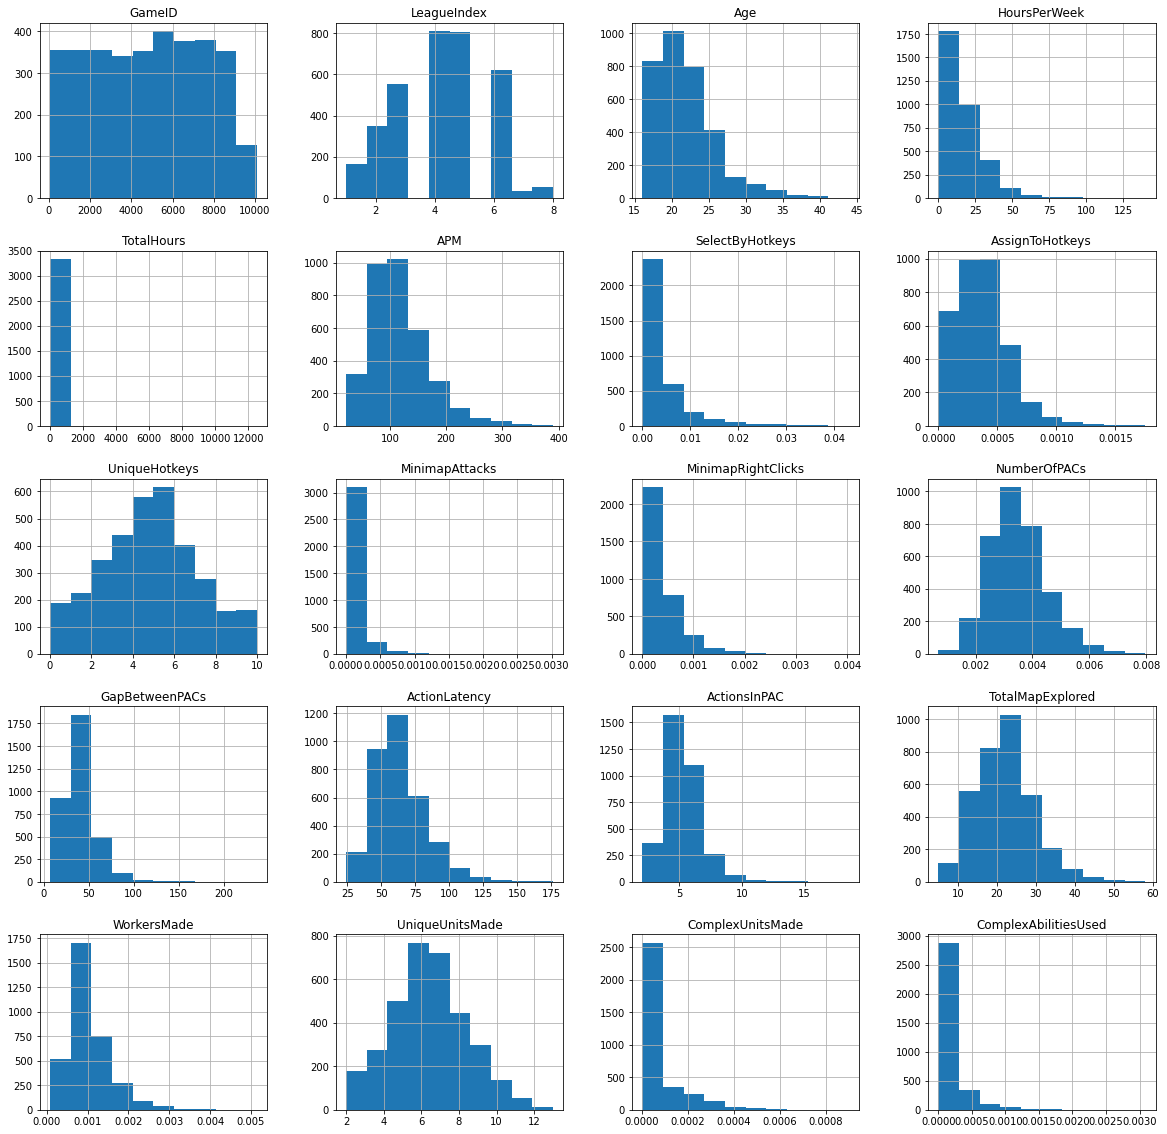

In [130]:
histogram = df.hist(figsize = (20,20))
plt.show()

Looking at the distribution of each variable, we can say that it is mostly gaussian and positively skewed. We do have some outliers that reduce the visibility but we could imagine that the value distributions match the league index distribution.  
Therefore, as the data is right-skewed our future model could have trouble predicting accurate leagues when using high values.

In [131]:
skew = []
for column in df.columns:
    skew.append(df[column].skew())
skews = pd.DataFrame(data = skew, index = df.columns, columns = ['Skewness'])
skews

,Skewness
GameID,-0.009147
LeagueIndex,-0.163358
Age,1.152388
HoursPerWeek,2.453447
TotalHours,57.533104
APM,1.204450
SelectByHotkeys,2.965329
AssignToHotkeys,1.141317
UniqueHotkeys,0.208279
MinimapAttacks,4.819162


As we can see, almost all of our features are positively skewed. Which could lead to errors in predictions since most models assume that data is following a gaussian distribution.   
To solve this issue, we will apply a log  and a square root transform to our data. We cannot apply a Box Cox transform since we have negative data. Even if our log transform is more performant than square root, we have some 0 which make it impossible to apply a log transform. This is why we apply two different transforms.

In [132]:
apply_sqrt = ['HoursPerWeek', 'TotalHours', 'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']
apply_log = ['Age', 'APM', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade']
skew = []
for column in df.columns:
    if column in apply_sqrt:
        df[column] = np.sqrt(df[column])
        skew.append(df[column].skew())
    elif column in apply_log:
        df[column] = np.log(df[column])
        skew.append(df[column].skew())
skews = pd.DataFrame(data = skew, index = df.columns[2:], columns = ['Skewness'])
skews

,Skewness
Age,0.563382
HoursPerWeek,0.830063
TotalHours,31.388773
APM,-0.143362
SelectByHotkeys,1.306835
AssignToHotkeys,0.042101
UniqueHotkeys,-1.047075
MinimapAttacks,1.133663
MinimapRightClicks,0.707783
NumberOfPACs,-0.472578


The result is not perfect but it is already better. Our data distribution is closer to gaussian.

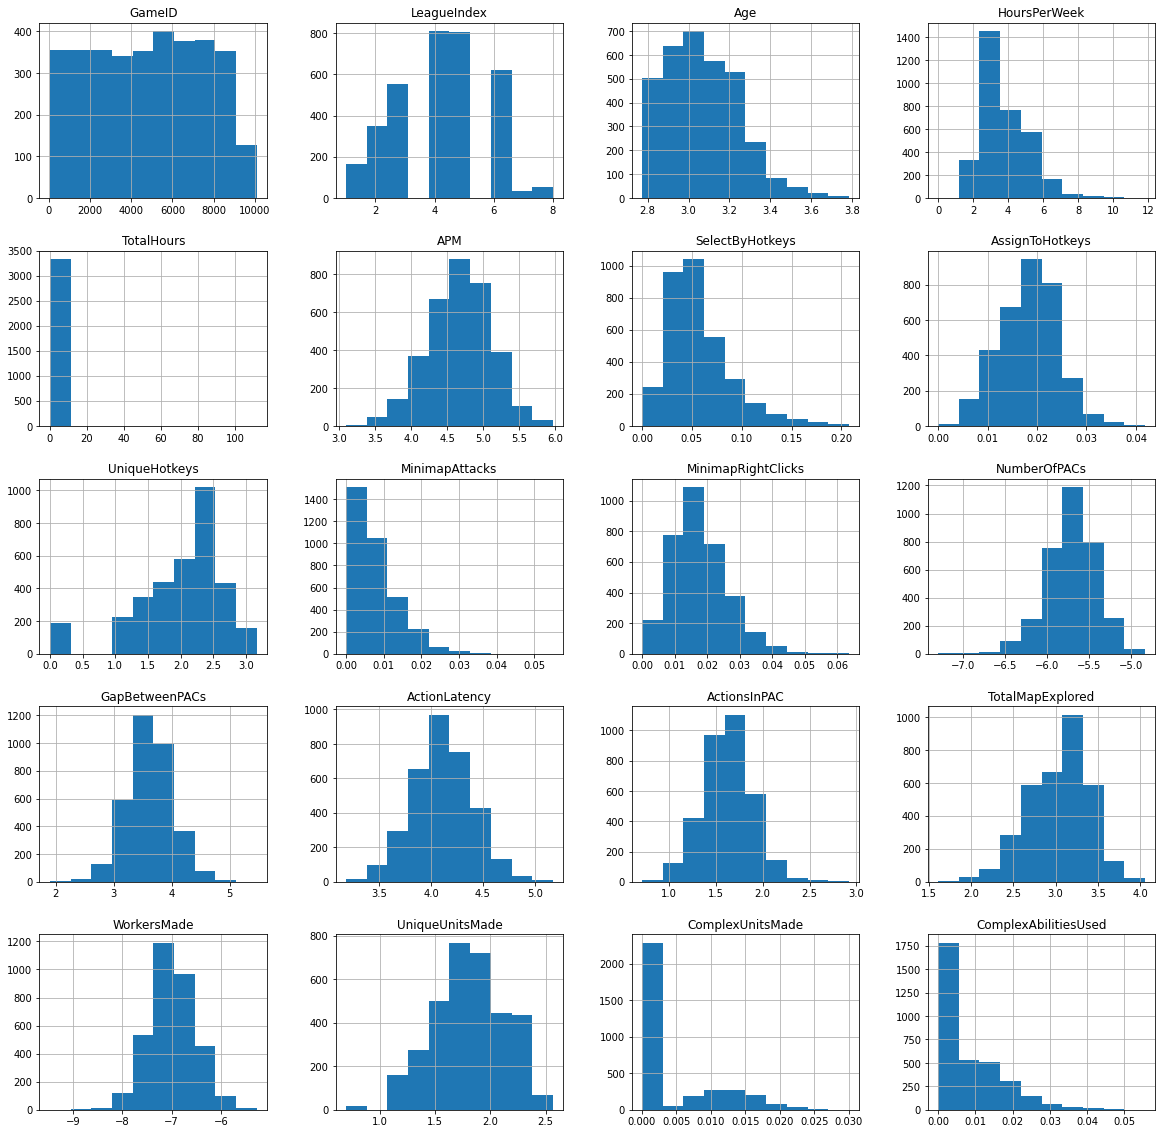

In [133]:
histogram = df.hist(figsize = (20,20))
plt.show()

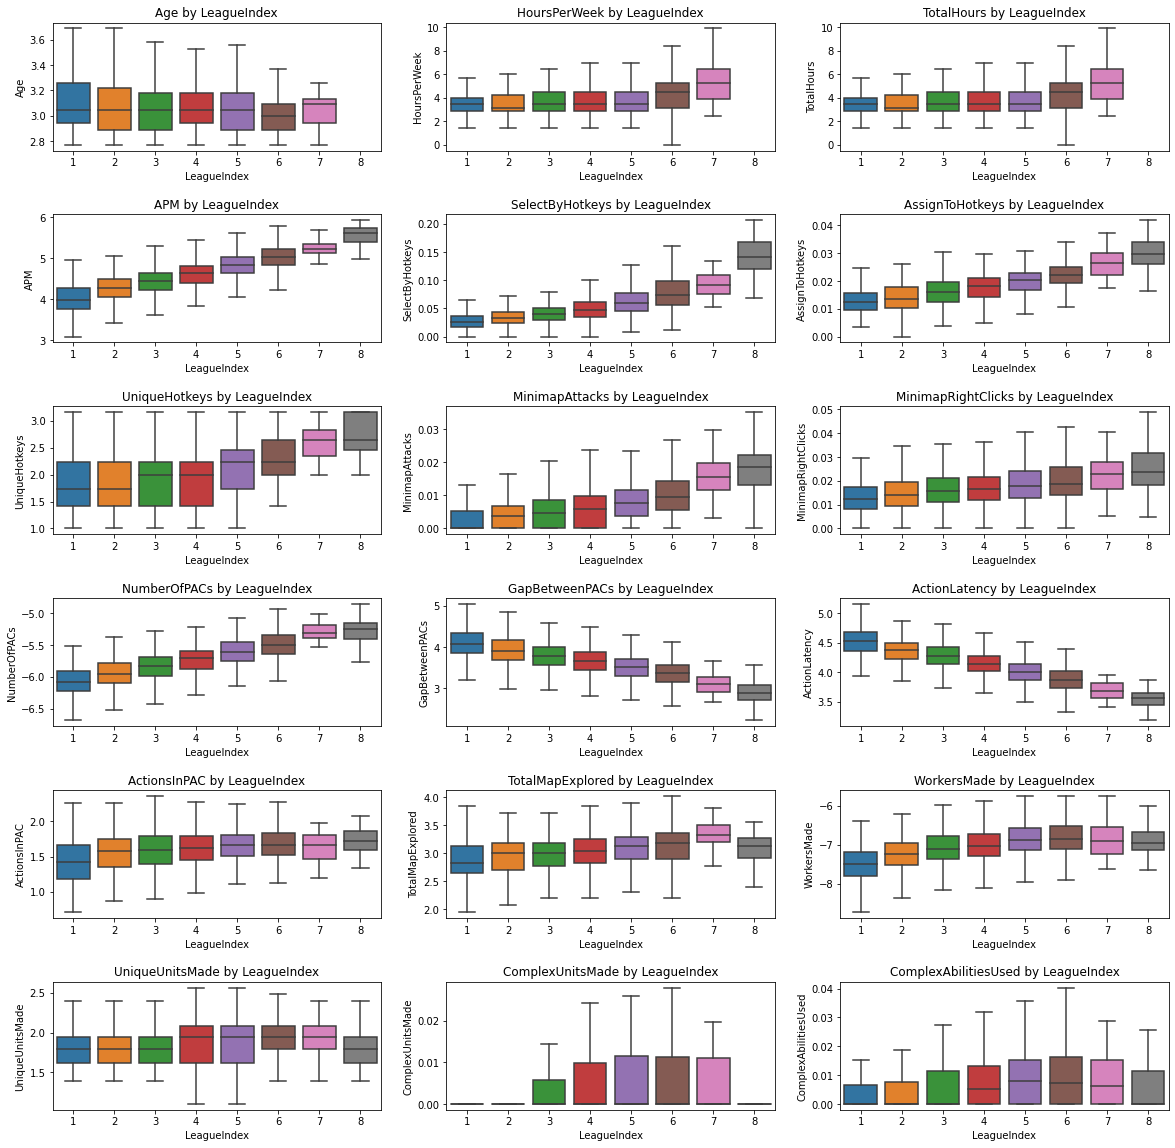

In [134]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace = 0.5)
nrow = 6
ncol = 3
n = 1
my_plots = {}
for column in df.columns:
    if ((column == 'GameID') or (column == 'LeagueIndex')):
        continue
    ax = fig.add_subplot(nrow, ncol, n)
    title = ("{0} by LeagueIndex".format(column))
    sns.boxplot(x = "LeagueIndex", y = column, data = df, showfliers = False).set_title(title)
    n += 1
    
plt.show()


Here we have a boxplot per variable by league index so that we can have an idea of the distribution of each variable per league.  
For a better visibitily, outliers have been left out.
At first glance, what we can say is that the higher the league index, the higher the APM, SelectByHotKeys, AssignToHotKeys, UniqueHotKeys, MinimapAttacks, MinimapRightClicks and NumberOfPACs. Also, the higher the league index, the lower the GapBetweenPACs and ActionLatency.  
For now, the other variables do not strike as meaningful but we may be proven wrong later on.  
We can also say that the age may not be relevant to classify our data even though in the 7th league, players seem to be older. Moreover, the amount of time spent on the game increases as the league increases but there is not a massive difference between all of our leagues except 6 and 7.  
**Do these repartitions seem logical?**  
Yes. The number of Actions Per Minute is obviously higher in an advanced league since it requires habits and skill to master them and be able to do a series of actions. These APM can also be linked to the number of Hot Keys allocated and used since they are basically shortcuts that enable players to play faster and more efficiently. A high number of UniqueHotKeys can mean that a player diversifies his actions, he does not only use a single attack for example.  
Considering the <a href="https://liquipedia.net/starcraft2/Minimap">Minimap</a>, it shows an overview of the game but can also be used to do <a href="https://news.blizzard.com/en-us/starcraft2/6640645/game-guide-simplified-controls">actions</a> like attacks or retreat. The more a player uses it, the less it has to move and lose time doing so. Also, right clicks on the minimap enable complex actions and trigger automatically casted abilities. All of these variables show how much a player is trained, prepared and knows the game.   
The number of Perception Action Cycles refer to the amount of actions taken by the player after perceiving something, so the higher it is, the more aware he is. The lower the action latency and gaps between PCAs, the more responsive the player which is crucial in such a game. 

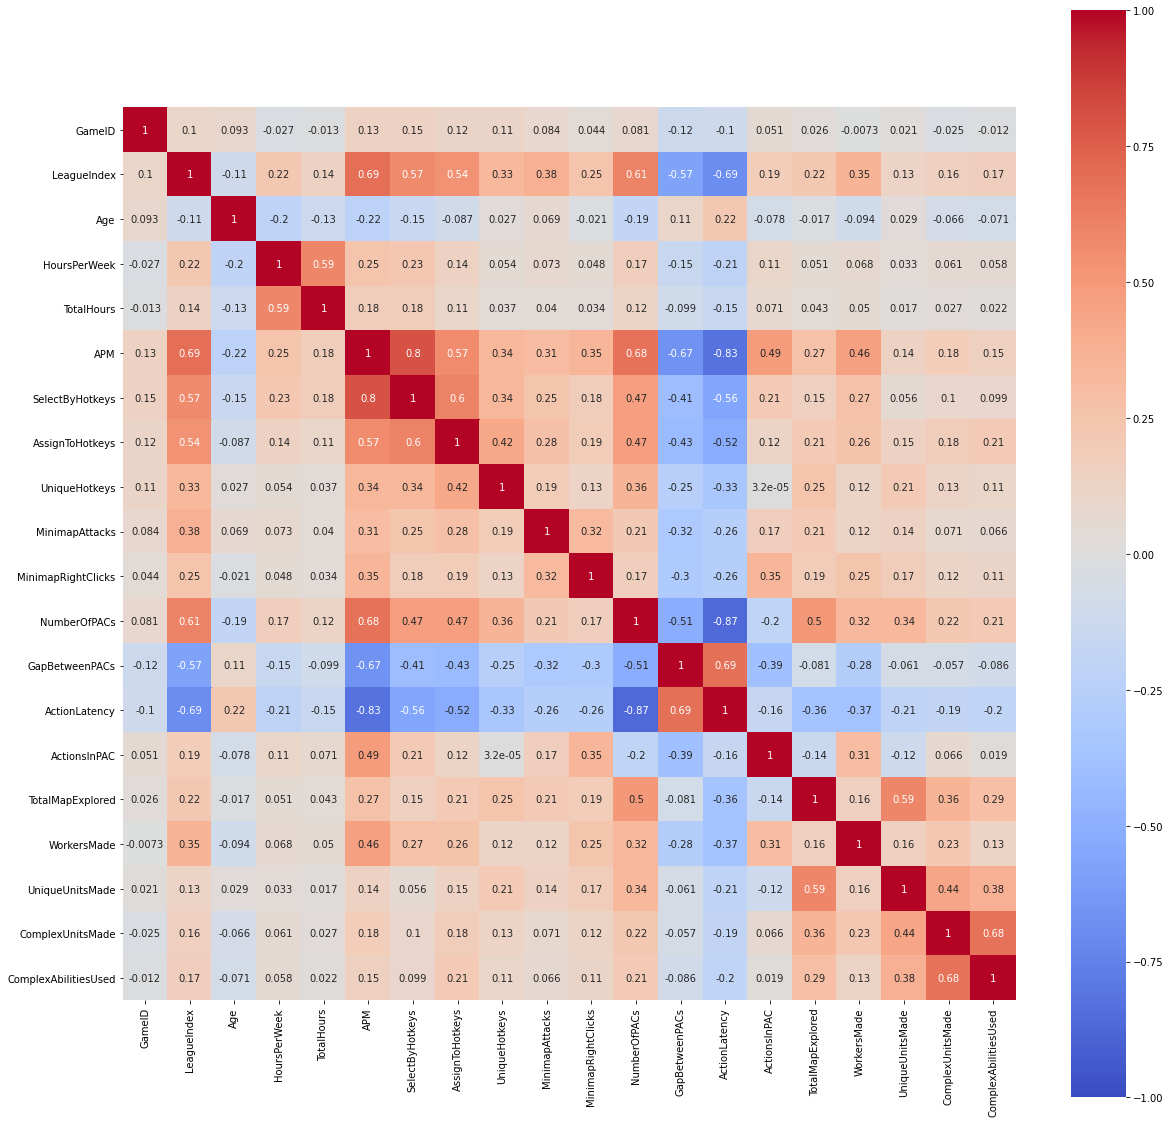

In [135]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True);

This correlation heatmap highlights the correlation between League index and the variables identified above. But we need to keep in mind that these variables are also strongly correlated together.  
Also, it is important to bear in mind that our target variable is **categorical** and is here represented by a numerical value between 1 to 8 which can not translate the differences between leagues. Indeed, looking <a href="https://www.rankedftw.com/stats/leagues/1v1/#v=2&r=-2&sx=a">here</a>, we see that although the distance is not so important between Silver to Diamond leagues, this gap is much more important with Master and GrandMaster leagues. The percentage of players in these last two leagues is divided by 5 when we compare Diamond to Master and by 10 between Diamond and GrandMaster! Also, we do not have the exact numbers of professional players but one can only imagine that it is even more selective. Thus, the chosen scale that represents our target is not so accurate, it could be better to apply a logarithmic scale.

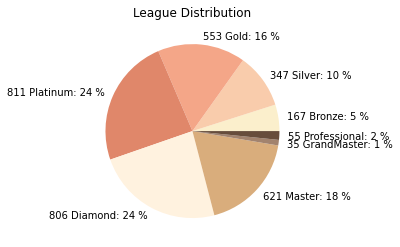

In [136]:
my_palette = ["#fbefcc", "#f9ccac", "#f4a688", "#e0876a", "#fff2df", "#d9ad7c", "#a2836e", "#674d3c"]
league_size = []
labels = ["Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master", "GrandMaster", "Professional"]
total = 3395
for i in range(1, 9):
    size = (df['LeagueIndex'] == i).sum()
    league_size.append(size)
    percentage = 100 * size / total
    labels[i - 1] = str(size) + " " + labels[i - 1] +": " + str(round(percentage)) + " %"
    
plt.pie(league_size, labels = labels, colors = my_palette)
plt.title("League Distribution")
plt.show() 

In fact, looking at the distribution of our data, we can see that the only league well represented (corresponding to real-life data) is Diamond. The rest of them is either underrepresented (Bronze, Silver, Gold) or overrepresented (Platinum, Master, GrandMaster and Professional) which can lead to errors in predictions.  
This is due to the way data was collected: through social media and gaming communities where players in higher leagues are usually more involved.

## Feature Selection

### PCA

Running a PCA will enable us to see which features explain the most variation in our data. We'll therefore be able to focus on the most meaningful variables for prediction.

#### PCA with all the features

In [137]:
# Separating out the features
x = df.drop(columns=['LeagueIndex', 'GameID'])
x = x.dropna()
col = x.columns
# Separating out the target
y = df.loc[:, ['LeagueIndex']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [138]:
pca = PCA()
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

In [139]:
finalDf = pd.concat([principalDf, df[['LeagueIndex']]], axis = 1)

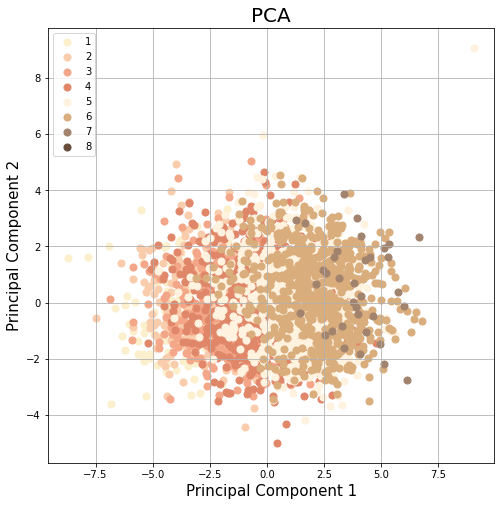

In [140]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)
targets = [1, 2, 3, 4, 5, 6, 7, 8]
colors = my_palette
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['LeagueIndex'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 0]
               , finalDf.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

As we can see from the above graph, even when reducing dimensions, the data is overlapping, not well separated. But we can see that there seems to be an order, the leagues are ordered from 8 to 1 from the left to the right.

In [141]:
pca.explained_variance_ratio_

array([0.29373576, 0.12248482, 0.0881386 , 0.08169888, 0.06492825,
       0.05607043, 0.04490407, 0.04259205, 0.03791493, 0.03361692,
       0.03179965, 0.02554498, 0.0223577 , 0.0209417 , 0.01643398,
       0.01269199, 0.00383905, 0.00030623])

The explained variance ratio shows that the two first principal components (PCs) explain around 41 % of the variation of our model.  
Let's see what is the most important feature to each PC.

In [142]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on each component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = col
# get the names of these features
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
print("Feature contributing the most to according PCs:")
df_pcs = pd.DataFrame.from_dict(dic, orient = 'index', columns = ['Feature'])
df_pcs['Variance explained'] = pca.explained_variance_ratio_

df_pcs

Feature contributing the most to according PCs:


,Feature,Variance explained
PC0,APM,0.293736
PC1,UniqueUnitsMade,0.122485
PC2,TotalHours,0.088139
PC3,ActionsInPAC,0.081699
PC4,MinimapAttacks,0.064928
PC5,AssignToHotkeys,0.056070
PC6,WorkersMade,0.044904
PC7,Age,0.042592
PC8,UniqueHotkeys,0.037915
PC9,WorkersMade,0.033617


What we can see here is that the main features for each component are related to actions taken during the game. However, PC 3 is really related to the amount of time spent playing.  
But, what if we only had a replay of the game and did not have access to these last features?

#### PCA without time and age

In [143]:
# Separating out the features
x = df.drop(columns=['LeagueIndex', 'GameID', 'TotalHours', 'HoursPerWeek', 'Age'])
x = x.dropna()
col = x.columns
# Separating out the target
y = df.loc[:, ['LeagueIndex']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
finalDf = pd.concat([principalDf, df[['LeagueIndex']]], axis = 1)

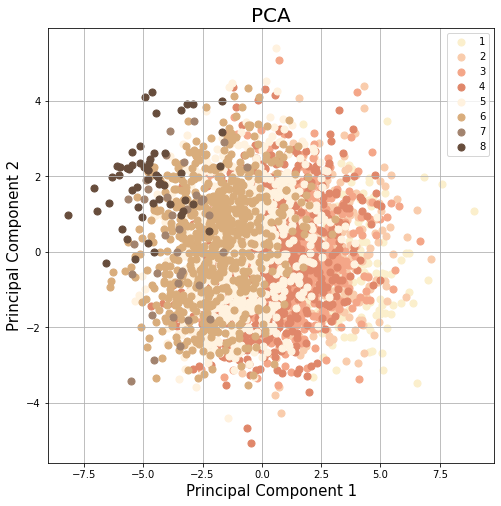

In [144]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)
targets = [1, 2, 3, 4, 5, 6, 7, 8]
colors = my_palette
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['LeagueIndex'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 0]
               , finalDf.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

The order of the variables is slightly different but the data is still overlapping.

In [145]:
pca.explained_variance_ratio_

array([0.3489705 , 0.14592573, 0.09964178, 0.07259808, 0.06334342,
       0.05212172, 0.04413073, 0.04022781, 0.03842119, 0.03001448,
       0.02496573, 0.01997906, 0.01486301, 0.00444056, 0.0003562 ])

As we can see now, our two first PCs explain around 48 % of the variance of our data which is better than with all our variables.

In [146]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on each component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = col
# get the names of these features
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
print("Feature contributing the most to according PCs:")
df_pcs = pd.DataFrame.from_dict(dic, orient = 'index', columns = ['Feature'])
df_pcs['Variance explained'] = pca.explained_variance_ratio_

df_pcs

Feature contributing the most to according PCs:


,Feature,Variance explained
PC0,APM,0.348971
PC1,UniqueUnitsMade,0.145926
PC2,ActionsInPAC,0.099642
PC3,MinimapAttacks,0.072598
PC4,UniqueHotkeys,0.063343
PC5,WorkersMade,0.052122
PC6,MinimapAttacks,0.044131
PC7,SelectByHotkeys,0.040228
PC8,MinimapRightClicks,0.038421
PC9,AssignToHotkeys,0.030014


In order to select the most important features to train our model, we ran a PCA earlier and now we will run an ANOVA test to get the decomposition of our variance and identify the most influential features. 

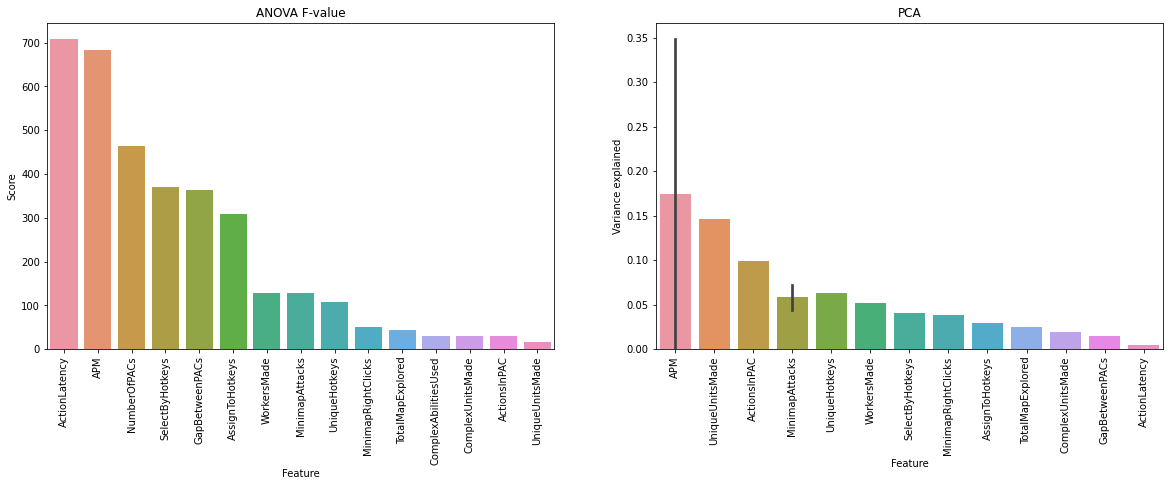

In [147]:

def plot_scores():
    def get_k_best(data, target, method, k):
        skb = SelectKBest(method, k = k)
        skb.fit(data.values, target.values)
        fs_indices = np.argsort(skb.scores_)[::-1]

        return pd.DataFrame({"Feature": data.columns[fs_indices].values, 
                      "Score": skb.scores_[fs_indices]})
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
    plt.subplots_adjust(left = None, bottom = None, right = None, top = None, wspace = None, hspace = 0.6)
    
    p = sns.barplot(x = 'Feature', y = 'Score', data = get_k_best(df_stan, leagues, f_classif, len(df_stan.columns)), ax = axes[0])
    p.set_xticklabels(p.get_xticklabels(), rotation = 90)
    p.set_title("ANOVA F-value")
    plot = sns.barplot(x = df_pcs['Feature'], y = df_pcs['Variance explained'], data = df_pcs, ax = axes[1])
    plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
    plot.set_title("PCA")
    
plot_scores()


According to these plots, we can see 6 features standing out: ActionLatency, APM, GapBetweenPACs, NumberOfPACs, SelectByHotKeys and AssignToHotKeys. 

## Data Preparation

### Preprocessing data

First, let's drop the columns that will not be useful for our predictions: the data that we cannot gather simply by watching a game replay.

In [148]:
to_drop = ['Age', 'GameID', 'HoursPerWeek', 'TotalHours']
df = df.drop(columns = to_drop)
leagues = df.LeagueIndex
df_data = df.drop(columns = 'LeagueIndex')

As mentioned in the Data Vizualization part, our target is imbalanced which can result in issues when trying to predict individuals of an under-populated category. Indeed, our model would not have enough data to learn how to predict if a player is a GrandMaster, a professional or in the Bronze league. To avoid this issue, we will merge the classes that are under-represented with their closest league in terms of level.  
Here is the current distribution in each class.

In [149]:
print('Population in each League: ')
leagues.value_counts()

Population in each League: 


4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: LeagueIndex, dtype: int64

Let's merge Bronze with Silver (1 and 2) and Master with GrandMaster and Professional (6, 7 and 8).

In [150]:
# Reencode
leagues.replace({2:1, 7:6, 8:6}, inplace=True)
# New Value Counts
print('Population in each League after merging: ')
leagues.value_counts()

Population in each League after merging: 


4    811
5    806
6    711
3    553
1    514
Name: LeagueIndex, dtype: int64

Standardizing our data is important since our columns have different scales and units. Because of that, one feature could contribute more to our model than another one, creating a bias. The idea of standardization is to end up with a mean of 0 and standard deviation of 1.

In [151]:
def standardize_data(data):
    scaler = StandardScaler()
    data_stan = scaler.fit_transform(data)
    
    # When the data has been transformed, a np.array is returned,
    # So we have to convert it back to a dataframe, and insert column names
    return pd.DataFrame(data_stan, columns = data.columns)
    
df_stan = standardize_data(df_data)
df_stan.describe()

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3.395000e+03,3.395000e+03,3.395000e+03,3.395000e+03,3.395000e+03,3.395000e+03,3.395000e+03,3.395000e+03,3.395000e+03,3.395000e+03,3.395000e+03,3.395000e+03,3.395000e+03,3395.000000,3.395000e+03
mean,-5.190415e-16,-4.185819e-17,-3.348655e-17,-2.678924e-16,-8.790219e-17,-1.255746e-16,-5.692714e-16,-1.758044e-16,-1.598983e-15,2.009193e-16,-6.195012e-16,-1.046455e-17,7.283325e-16,0.000000,-3.767237e-17
std,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147,1.000147e+00
min,-3.604682e+00,-1.778249e+00,-3.114451e+00,-2.807982e+00,-1.100218e+00,-2.055734e+00,-5.343955e+00,-4.358843e+00,-3.215062e+00,-3.419810e+00,-4.082516e+00,-5.290069e+00,-3.696234e+00,-0.640778,-8.356634e-01
25%,-6.596021e-01,-6.746729e-01,-6.959089e-01,-3.367777e-01,-1.100218e+00,-6.811108e-01,-6.292716e-01,-6.407627e-01,-6.617328e-01,-6.509847e-01,-5.867580e-01,-6.422059e-01,-7.242092e-01,-0.640778,-8.356634e-01
50%,3.019340e-02,-2.225673e-01,6.330022e-02,4.551889e-02,-1.526733e-01,-1.071583e-01,7.613793e-02,-3.932589e-02,-9.242346e-03,7.949093e-03,1.497399e-01,-4.226040e-02,-1.328421e-01,-0.640778,-3.429338e-01
75%,6.689705e-01,4.510115e-01,6.654167e-01,6.868286e-01,5.345563e-01,5.776118e-01,6.506857e-01,6.538506e-01,6.472352e-01,6.403472e-01,7.347423e-01,6.595293e-01,8.002661e-01,0.784088,6.377863e-01
max,2.967169e+00,4.680869e+00,3.969721e+00,1.703799e+00,7.139421e+00,5.327049e+00,2.949685e+00,4.682587e+00,3.663147e+00,4.845066e+00,2.918867e+00,3.659261e+00,2.375030e+00,3.986844,5.239939e+00


Let's split our data so that we can train and test our model later.

In [152]:
df_train, df_test, leagues_train, leagues_test = train_test_split(df_stan, leagues, test_size = 0.3, random_state = 4035, stratify = leagues)

print(f"Training dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")
print(f"Training target shape: {leagues_train.shape}")
print(f"Test target shape: {leagues_test.shape}")

Training dataset shape: (2376, 15)
Test dataset shape: (1019, 15)
Training target shape: (2376,)
Test target shape: (1019,)


## Fitting a logistic regression 

We will try different algorithm of classification, first with all the features but also, only with the 6 most important features identified earlier.

In [153]:
unwanted_features = ['UniqueHotkeys',
       'MinimapAttacks', 'MinimapRightClicks',
       'ActionsInPAC', 'TotalMapExplored',
       'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade',
       'ComplexAbilitiesUsed']
df_train6 = df_train.drop(columns = unwanted_features)
df_test6 = df_test.drop(columns = unwanted_features)

In [154]:
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(df_train, leagues_train)
logreg6 = LogisticRegression(max_iter = 1000)
logreg6.fit(df_train6, leagues_train)

LogisticRegression(max_iter=1000)

Here are the coefficients found by the logistic regression model for the 6 most important features.

In [155]:
pd.DataFrame(np.concatenate([logreg6.intercept_.reshape(-1,1),
                             logreg6.coef_],axis = 1),
                          columns = ["intercept"] + list(df_train6.columns)).T

,0,1,2,3,4
intercept,-1.053812,0.010240,0.752425,0.597684,-0.306537
APM,-0.515376,0.107108,0.162207,0.353708,-0.107647
SelectByHotkeys,-0.296956,-0.310158,-0.103655,0.082674,0.628095
AssignToHotkeys,-0.499211,-0.109089,0.003367,0.152273,0.452661
NumberOfPACs,-0.213366,-0.015592,-0.031529,0.081721,0.178766
GapBetweenPACs,0.372748,0.231464,0.056312,-0.200320,-0.460204
ActionLatency,0.753135,0.708990,0.100305,-0.426722,-1.135708


We will store our models and predictions in a dictonnary and an array so that we can compare them later.

In [156]:
compare_model_acc = {}
predictions = []

Splitting our dataset is important so that we will train our model on a part of the data and then test it on the other one. Thus, avoiding overfitting.  
The way our data is split influences our model. Indeed, even if we split randomly, it is possible to have better splits than others.  
For example, our data could be split in such a way that we have a majority of one class in our training set and a very few individuals of the other ones. Then, our model would be well trained to predict one class and not so accurate for the others.  
By trying different random_states, we'll be able to identify the best split, the one that gives the best accuracy.  
The code is commented because it takes a relatively long time to run.

In [157]:
"""logreg = LogisticRegression(max_iter = 1000)
def get_best_seed():
    best_seed = 0
    best_accuracy = 0
    for i in range(5000):
        df_train, df_test, leagues_train, leagues_test = train_test_split(df_stan, leagues, test_size = 0.3, random_state = i, stratify = leagues)
        unwanted_features = ['UniqueHotkeys',
       'MinimapAttacks', 'MinimapRightClicks',
       'ActionsInPAC', 'TotalMapExplored',
       'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade',
       'ComplexAbilitiesUsed']
        df_train6 = df_train.drop(columns = unwanted_features)
        df_test6 = df_test.drop(columns = unwanted_features)
        logreg.fit(df_train, leagues_train)
        current_acc = accuracy_score(y_true = leagues_test, y_pred = logreg.predict(df_test))
        if (current_acc > best_accuracy):
            best_accuracy = current_acc
            best_seed = i
    return best_seed, best_accuracy
seed, acc = get_best_seed()
print(seed) #4035
print(acc) #0.49362119725220804
"""

"logreg = LogisticRegression(max_iter = 1000)\ndef get_best_seed():\n    best_seed = 0\n    best_accuracy = 0\n    for i in range(5000):\n        df_train, df_test, leagues_train, leagues_test = train_test_split(df_stan, leagues, test_size = 0.3, random_state = i, stratify = leagues)\n        unwanted_features = ['UniqueHotkeys',\n       'MinimapAttacks', 'MinimapRightClicks',\n       'ActionsInPAC', 'TotalMapExplored',\n       'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade',\n       'ComplexAbilitiesUsed']\n        df_train6 = df_train.drop(columns = unwanted_features)\n        df_test6 = df_test.drop(columns = unwanted_features)\n        logreg.fit(df_train, leagues_train)\n        current_acc = accuracy_score(y_true = leagues_test, y_pred = logreg.predict(df_test))\n        if (current_acc > best_accuracy):\n            best_accuracy = current_acc\n            best_seed = i\n    return best_seed, best_accuracy\nseed, acc = get_best_seed()\nprint(seed) #4035\nprint(acc) #0.49362

We get our predictions and save them for later comparison.

In [158]:
pred6 = logreg6.predict(df_test6)
pred = logreg.predict(df_test)
acc = accuracy_score(y_true = leagues_test, y_pred = pred)
predictions.append(pred)
compare_model_acc['Logreg'] = acc
acc = accuracy_score(y_true = leagues_test, y_pred = pred6)
predictions.append(pred6)
compare_model_acc['Logreg6'] = acc

Here is a function to plot a confusion matrix.

In [159]:
def plot_confusion_matrix(actual, prediction):
    cf_mat = confusion_matrix(y_true = actual, y_pred = prediction)
    fig, ax = plt.subplots(figsize = (7.5, 7.5))
    ax.matshow(cf_mat, cmap = plt.cm.Blues, alpha = 0.3)
    for i in range(cf_mat.shape[0]):
        for j in range(cf_mat.shape[1]):
            ax.text(x = j, y = i,s = cf_mat[i, j], va = 'center', ha = 'center', size = 'xx-large')

    plt.xlabel('Prediction', fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    return fig

## Decision Tree

Now that we have a first model, let's try a decision tree.

In [160]:
def train_using_gini(X_train, y_train): 
  
    clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 100,max_depth=3, min_samples_leaf=5) 
  
    clf_gini.fit(X_train, y_train) 
    return clf_gini 
      
def tarin_using_entropy(X_train, y_train): 
  
    clf_entropy = DecisionTreeClassifier( 
            criterion = "entropy", random_state = 100, 
            max_depth = 3, min_samples_leaf = 5) 
  
    clf_entropy.fit(X_train, y_train) 
    return clf_entropy 
  
def prediction(X_test, clf_object): 
  
    y_pred = clf_object.predict(X_test) 
    return y_pred 

In [161]:
clf_gini = train_using_gini(df_train, leagues_train) 
clf_entropy = tarin_using_entropy(df_train, leagues_train) 
pred_gini = prediction(df_test, clf_gini)
pred_entropy = prediction(df_test, clf_entropy)

clf_gini6 = train_using_gini(df_train6, leagues_train) 
clf_entropy6 = tarin_using_entropy(df_train6, leagues_train) 
pred_gini6 = prediction(df_test6, clf_gini6)
pred_entropy6 = prediction(df_test6, clf_entropy6)
predictions.append(pred_gini)
predictions.append(pred_gini6)
predictions.append(pred_entropy)
predictions.append(pred_entropy6)

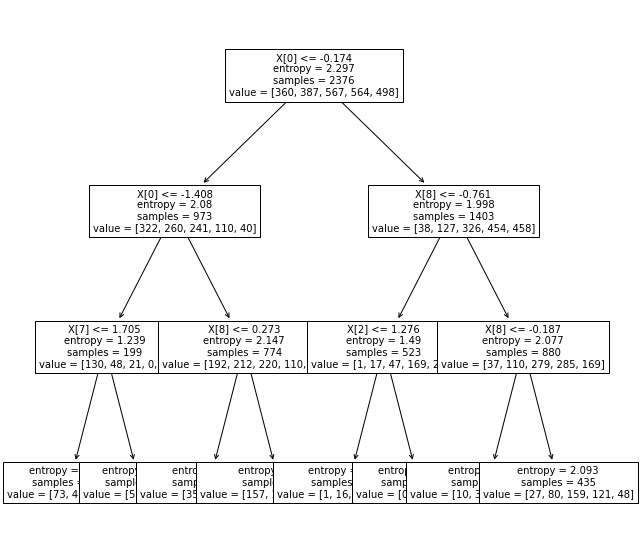

In [162]:
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(clf_entropy, fontsize=10)
plt.show()

In [163]:
acc = accuracy_score(y_true = leagues_test, y_pred = pred_gini)
compare_model_acc['Decision tree Gini'] = acc

In [164]:
acc = accuracy_score(y_true = leagues_test, y_pred = pred_entropy)
compare_model_acc['Decision tree Entropy'] = acc

In [165]:
acc = accuracy_score(y_true = leagues_test, y_pred = pred_gini6)
compare_model_acc['Decision tree Gini6'] = acc

In [166]:
acc = accuracy_score(y_true = leagues_test, y_pred = pred_entropy6)
compare_model_acc['Decision tree Entropy6'] = acc

## Random Forest

The Random Forest algorithm is basically a combination of multiple decision trees to find the most accurate model so it should perform better than the decision tree algorithm.

In [167]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 34)
rf.fit(df_train, leagues_train)
rf6 = RandomForestClassifier(n_estimators = 1000, random_state = 34)
rf6.fit(df_train6, leagues_train)

RandomForestClassifier(n_estimators=1000, random_state=34)

Similar to what we did earlier, we found the best random_state for our Random Forest Classifier.

In [168]:
"""
def get_best_rnd_state():
    best_seed = 0
    best_accuracy = 0
    for i in range(100):
        rf = RandomForestClassifier(n_estimators = 1000, random_state = i)
        rf.fit(df_train, leagues_train)
        current_acc = accuracy_score(y_true = leagues_test, y_pred = rf.predict(df_test))
        if (current_acc > best_accuracy):
            best_accuracy = current_acc
            best_seed = i
    return best_seed, best_accuracy
seed, acc = get_best_rnd_state()
print(seed) #34
print(acc) #0.477
"""

'\ndef get_best_rnd_state():\n    best_seed = 0\n    best_accuracy = 0\n    for i in range(100):\n        rf = RandomForestClassifier(n_estimators = 1000, random_state = i)\n        rf.fit(df_train, leagues_train)\n        current_acc = accuracy_score(y_true = leagues_test, y_pred = rf.predict(df_test))\n        if (current_acc > best_accuracy):\n            best_accuracy = current_acc\n            best_seed = i\n    return best_seed, best_accuracy\nseed, acc = get_best_rnd_state()\nprint(seed) #34\nprint(acc) #0.477\n'

In [169]:
rf_pred = rf.predict(df_test)
predictions.append(rf_pred)
acc = accuracy_score(y_true = leagues_test, y_pred = rf_pred)
compare_model_acc['Random Forest'] = acc

In [170]:
rf_pred6 = rf6.predict(df_test6)
predictions.append(rf_pred6)
acc = accuracy_score(y_true = leagues_test, y_pred = rf_pred6)
compare_model_acc['Random Forest6'] = acc

In [171]:
df_models_accuracy = pd.DataFrame.from_dict(compare_model_acc, orient = 'index', columns = ['Accuracy'])
df_models_accuracy

,Accuracy
Logreg,0.487733
Logreg6,0.480864
Decision tree Gini,0.442591
Decision tree Entropy,0.424926
Decision tree Gini6,0.442591
Decision tree Entropy6,0.424926
Random Forest,0.477920
Random Forest6,0.443572


As we can see here, our very first model is the one that performs the best with almost 49 % of accuracy. The Random Forest is also close to the logistic regression.  
What we can also say is that even with only 6 features our models are performant.  
Next, we will use gridsearching to find the best parameters for our most promising models: Logistic Regression and Random Forest.

## GridSearching

We will try different parameters for our random forest.

In [172]:
param_grid = { 
    'n_estimators': [200, 500, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

The actual gridsearching is commented because it requires a long time to run but you can see the best parameters below.

In [173]:
CV_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv= 5)
#CV_rf.fit(df_train, leagues_train)

In [174]:
#print(CV_rf.best_params_) #{'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}

Now that we have our best parameters, let's fit a random forest model.

In [175]:
rfc = RandomForestClassifier(random_state = 34, max_features = 'auto', n_estimators = 100, max_depth = 4, criterion = 'gini')

In [176]:
rfc.fit(df_train, leagues_train)

RandomForestClassifier(max_depth=4, random_state=34)

In [177]:
rfc_pred = rfc.predict(df_test)
predictions.append(rfc_pred)
acc = accuracy_score(y_true = leagues_test, y_pred = rfc_pred)
compare_model_acc['Random Forest GridSearch'] = acc

Same thing with logistic regression and different parameters.  
Again, since it take a long time to run, it is commented.

In [178]:
param_grid_logreg = {
    'penalty': ['l1','l2'], 
    'C': [0.001,0.01,0.1,1,10,100,1000]
}

In [179]:
"""param_grid_logreg = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
CV_logreg = GridSearchCV(estimator = logreg, param_grid = param_grid_logreg, cv= 5)
CV_logreg.fit(df_train, leagues_train)
print(CV_logreg.best_params_) # {'C': 0.1, 'penalty': 'l2'}"""

"param_grid_logreg = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}\nCV_logreg = GridSearchCV(estimator = logreg, param_grid = param_grid_logreg, cv= 5)\nCV_logreg.fit(df_train, leagues_train)\nprint(CV_logreg.best_params_) # {'C': 0.1, 'penalty': 'l2'}"

With this last model, we can see that our MSE and our R^2 are close which means that our model did not overfit.

In [180]:
logreg_best = LogisticRegression(max_iter = 1000, C = 0.1, penalty = 'l2')
logreg_best.fit(df_train, leagues_train)
pred_logreg_best = logreg_best.predict(df_test)
predictions.append(pred_logreg_best)
acc = accuracy_score(y_true = leagues_test, y_pred = pred_logreg_best)
compare_model_acc['Logistic Regression GridSearch'] = acc

mse_train = mean_squared_error(leagues_train, logreg_best.predict(df_train))
r2_train = r2_score(leagues_train, logreg_best.predict(df_train))
mse = mean_squared_error(leagues_test, predictions[-1])
r2 = r2_score(leagues_test, predictions[-1])
print("MSE Train: %.2f" % mse_train)
print("R2 Train: %.2f" % r2_train)
print("MSE Test: %.2f" % mse)
print("R2 Test: %.2f" % r2)

MSE Train: 1.68
R2 Train: 0.35
MSE Test: 1.51
R2 Test: 0.42


In [181]:
df_models_accuracy = pd.DataFrame.from_dict(compare_model_acc, orient = 'index', columns = ['Accuracy'])
df_models_accuracy

,Accuracy
Logreg,0.487733
Logreg6,0.480864
Decision tree Gini,0.442591
Decision tree Entropy,0.424926
Decision tree Gini6,0.442591
Decision tree Entropy6,0.424926
Random Forest,0.477920
Random Forest6,0.443572
Random Forest GridSearch,0.486752
Logistic Regression GridSearch,0.489696


When we compare our accuracy, we can see that gridsearching definitely improved our models and that the most accurate one is the logistic regression with 48.9 % of accuracy.

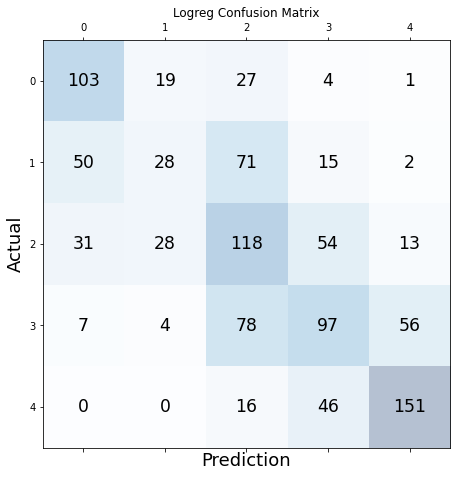

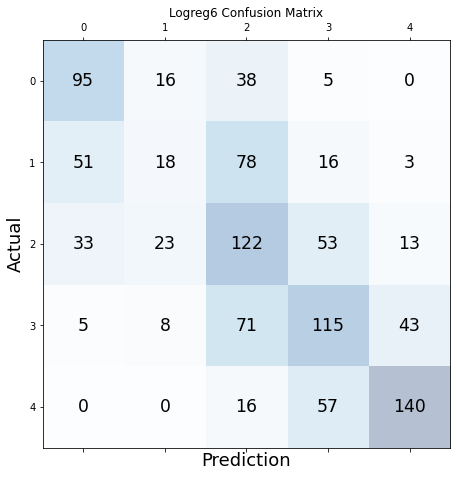

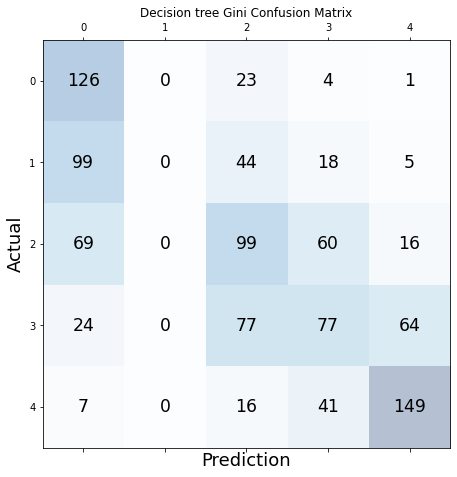

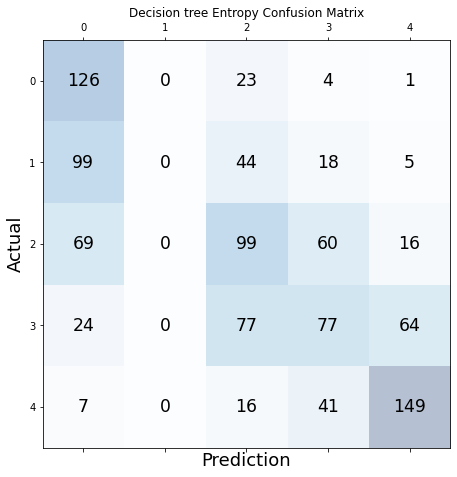

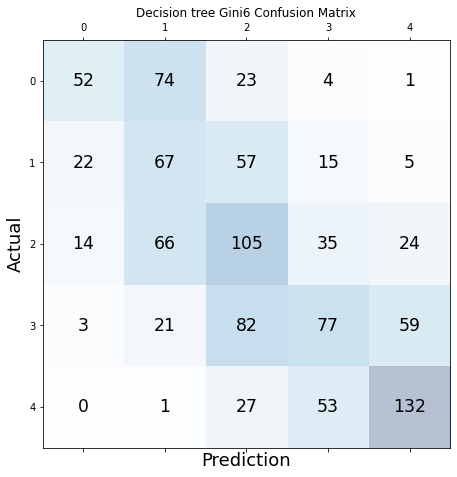

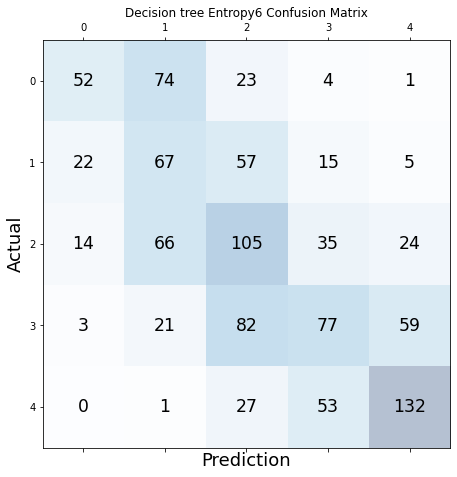

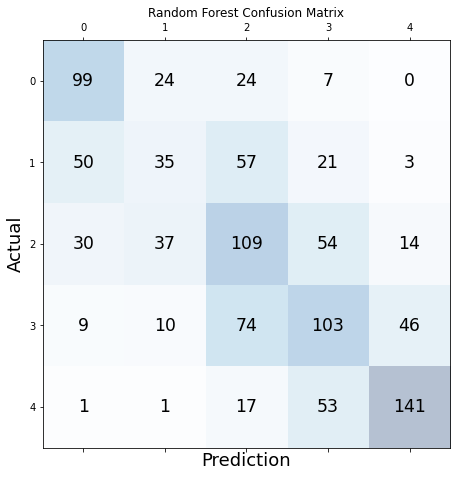

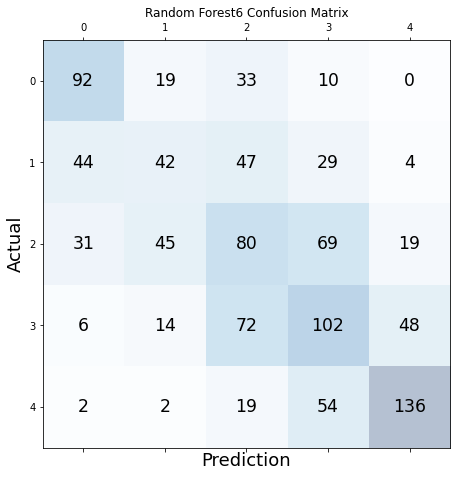

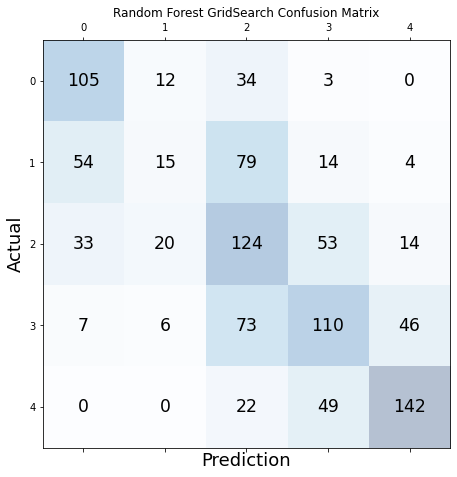

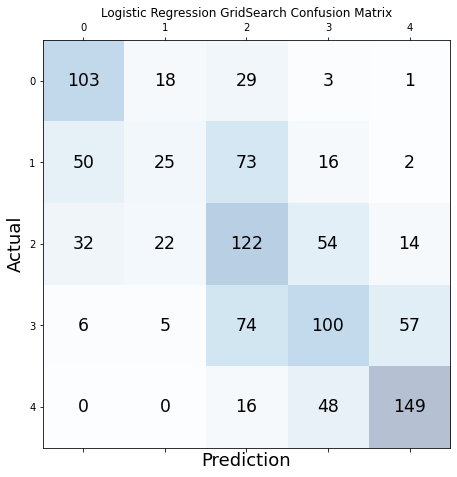

In [182]:
n = 1
my_plots = {}
for row in df_models_accuracy.index:
    title = ("{0} Confusion Matrix".format(row))
    plot_confusion_matrix(leagues_test, predictions[n-1])
    plt.title(title)
    n += 1
    
plt.show()

The confusion matrices are useful to see where our model does misclassification and to calculate other indicators such as the sensitivity of the model.  
Here is a plot of all of our models ordered by accuracy (ascending order).

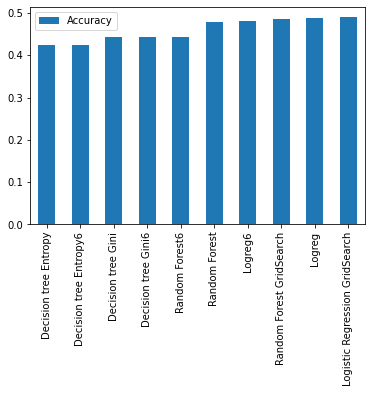

In [183]:
df_sorted = df_models_accuracy.sort_values('Accuracy')
plot = df_sorted.plot.bar()
plt.show()

Here are some classification metrics for our different models.

In [184]:
target_names = ['Bronze_Silver', 'Gold', 'Platinum', 'Diamond', 'Master_GrandMaster_Professional']
print('Logistic regression report:\n')
print(sklearn.metrics.classification_report(leagues_test, logreg.predict(df_test), target_names=target_names))
print('Decision Tree Gini report:\n')
print(sklearn.metrics.classification_report(leagues_test, pred_gini, target_names=target_names))
print('Random Forest report:\n')
print(sklearn.metrics.classification_report(leagues_test, rf_pred, target_names=target_names))
print('Random Forest after Grid Search report:\n')
print(sklearn.metrics.classification_report(leagues_test, rfc_pred, target_names=target_names))
print('Logistic Regression after Grid Search report:\n')
print(sklearn.metrics.classification_report(leagues_test, pred_logreg_best, target_names=target_names))

Logistic regression report:

                                 precision    recall  f1-score   support

                  Bronze_Silver       0.54      0.67      0.60       154
                           Gold       0.35      0.17      0.23       166
                       Platinum       0.38      0.48      0.43       244
                        Diamond       0.45      0.40      0.42       242
Master_GrandMaster_Professional       0.68      0.71      0.69       213

                       accuracy                           0.49      1019
                      macro avg       0.48      0.49      0.47      1019
                   weighted avg       0.48      0.49      0.47      1019

Decision Tree Gini report:

                                 precision    recall  f1-score   support

                  Bronze_Silver       0.39      0.82      0.53       154
                           Gold       0.00      0.00      0.00       166
                       Platinum       0.38      0.41      0.39 

C:\Users\Juliette\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juliette\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juliette\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Saving our most accurate model with Pickle

Let's save it for later use in our API.

In [185]:
logistic_reg_model_pkl = open('logreg.pkl', 'wb')
pickle.dump(logreg_best, logistic_reg_model_pkl)
logistic_reg_model_pkl.close()

We can also see if it is correctly saved:

In [186]:
loaded_model = pickle.load(open('logreg.pkl', 'rb'))
pred_loaded = loaded_model.predict(df_test)
acc = accuracy_score(y_true = leagues_test, y_pred = pred_loaded)
print(acc)

0.4896957801766438


In [187]:
pickle.dump(rfc, open('rf.pkl', 'wb'))
logistic_reg_model_pkl.close()